In [1]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [2]:
# Or you can do it like so:
"""import huggingface_hub
huggingface_hub.login()"""

'import huggingface_hub\nhuggingface_hub.login()'

In [3]:
from collections import Counter
import random
from pathlib import Path

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import softmax

In [5]:
import torch

In [6]:
import transformers  # hf
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

In [7]:
!pip install -U datasets evaluate accelerate gradio

In [8]:
import gradio as gr

In [9]:
import datasets, evaluate, accelerate

In [10]:
# Load dataset
# https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions
dataset_path = 'mrdbourke/learn_hf_food_not_food_image_captions'
data = datasets.load_dataset(dataset_path)

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

In [11]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [12]:
data.shape

{'train': (250, 2)}

In [13]:
data['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [14]:
data['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [15]:
data['train'].shuffle()[:3]

{'text': ['Watching TV together, a family has their dog stretched out on the floor',
  'Basketball hoop set up in a driveway',
  'Red brick fireplace with a mantel serving as a centerpiece'],
 'label': ['not_food', 'not_food', 'not_food']}

In [16]:
random.seed(19)
rnd_indexes = random.sample(range(len(data['train'])), 5)

for idx in rnd_indexes:
    sample = data['train'][idx]
    print(f"SAMPLE {idx}")
    print(f"[{sample['label']}] {sample['text']}\n")

SAMPLE 173
[not_food] Microscope set up on a table

SAMPLE 11
[not_food] Set of napkins arranged in a ring

SAMPLE 200
[not_food] Ceiling fan with lights illuminating a bedroom

SAMPLE 229
[food] Sushi platter featuring a rainbow of colors with salmon, tuna, and avocado.

SAMPLE 133
[food] Comforting lentil dal curry, featuring nutty lentils in a spiced sauce with onions and tomatoes, garnished with fresh cilantro leaves.



In [17]:
data['train'].unique('label')

['food', 'not_food']

In [18]:
type(data['train']['label'])

list

In [19]:
Counter(data['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [20]:
df = pd.DataFrame(data['train'])
df.shape

(250, 2)

In [21]:
df.sample(3)

,text,label
145,"Fragrant Thai green curry, featuring vegetable...",food
140,"A gourmet pizza with a pesto base, topped with...",food
16,A bowl of sliced honeydew with a sprinkle of s...,food


In [22]:
df['label'].value_counts()

,count
label,
food,125
not_food,125


In [23]:
id2label = {0: 'not_food', 1: 'food'}
label2id = {v: k for k, v in id2label.items()}

label2id

{'not_food': 0, 'food': 1}

In [24]:
type(data)

datasets.dataset_dict.DatasetDict

In [25]:
type(data['train'])

datasets.arrow_dataset.Dataset

In [26]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [27]:
# Convert label to numeric
def convert_label_to_id(itm):
    itm['label'] = label2id[itm['label']]
    return itm
data = data['train'].map(function=convert_label_to_id)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [28]:
# Note that `data` is now of type `Dataset` and not `DatasetDict`
data

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [29]:
data = data.train_test_split(test_size=.2, seed=19)
data  # Now, again, `data` is `DatasetDict`

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [30]:
# https://platform.openai.com/tokenizer

# https://huggingface.co/docs/transformers/en/main_classes/tokenizer
# https://huggingface.co/distilbert/distilbert-base-uncased

model_name = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_name,
    use_fast=True  # this requires Rust installed.
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [32]:
len(tokenizer.vocab)

30522

In [33]:
# Sequenecs longer than `model_max_length` will be truncated.
tokenizer.model_max_length

512

In [34]:
tokenizer.max_len_sentences_pair, tokenizer.max_len_single_sentence

(509, 510)

In [35]:
# N.B. it's not a simple mappting of words to numbers.
# It's a tokenizer.
# Note that tokens are not necessarily a mere word.
tokenizer('Machine Learning is Great.')

{'input_ids': [101, 3698, 4083, 2003, 2307, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [36]:
sentence = 'Yesterday I went to an Italien restaurant and ordered a delicious pasta.'
sentence_tokenized = tokenizer(sentence)


len(sentence.split()), len(sentence_tokenized['input_ids'])

(12, 17)

In [37]:
sentence_tokenized

{'input_ids': [101, 7483, 1045, 2253, 2000, 2019, 2009, 11475, 2368, 4825, 1998, 3641, 1037, 12090, 24857, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
tokenizer.vocab['python'], tokenizer.vocab['machine']

(18750, 3698)

In [39]:
tokenizer('Her name is JJ')

{'input_ids': [101, 2014, 2171, 2003, 29017, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [40]:
# 100 is for "[UNK]"
# note: the tokens in the tokenizer are lower-cased; hence the 100
tokenizer.convert_tokens_to_ids('R')

100

In [41]:
# Confirmation that `F1` is not in the tokenizer's vocab:
tokenizer.vocab.get('R', '100')

'100'

In [42]:
# As you see, id for '[PAD]' is 0
# id for '[UNK]' is 100
list(zip(tokenizer.all_special_ids, tokenizer.all_special_tokens))

[(100, '[UNK]'), (102, '[SEP]'), (0, '[PAD]'), (101, '[CLS]'), (103, '[MASK]')]

In [43]:
def get_ids_from_tokens(sentence):
    token_ids = tokenizer(sentence)['input_ids']
    return tokenizer.convert_ids_to_tokens(token_ids)

In [44]:
get_ids_from_tokens('R')

['[CLS]', 'r', '[SEP]']

In [45]:
get_ids_from_tokens('Her name is JJ')

['[CLS]', 'her', 'name', 'is', 'jj', '[SEP]']

In [46]:
# https://en.wikipedia.org/wiki/Awkwafina
get_ids_from_tokens('Her name is Awkwafina!')

['[CLS]',
 'her',
 'name',
 'is',
 'aw',
 '##k',
 '##wa',
 '##fin',
 '##a',
 '!',
 '[SEP]']

In [47]:
get_ids_from_tokens('two in German is zwei.')

['[CLS]', 'two', 'in', 'german', 'is', 'z', '##wei', '.', '[SEP]']

In [48]:
get_ids_from_tokens('TikTok is different that Twitch or YouTube.')

['[CLS]',
 'ti',
 '##kt',
 '##ok',
 'is',
 'different',
 'that',
 'twitch',
 'or',
 'youtube',
 '.',
 '[SEP]']

In [49]:
get_ids_from_tokens('helloooo there :)')

['[CLS]', 'hello', '##oo', '##o', 'there', ':', ')', '[SEP]']

In [50]:
get_ids_from_tokens('The house number of Dr. House is 221B.')

['[CLS]',
 'the',
 'house',
 'number',
 'of',
 'dr',
 '.',
 'house',
 'is',
 '221',
 '##b',
 '.',
 '[SEP]']

In [51]:
get_ids_from_tokens('I saw Elon Musk in a Mosque.')

['[CLS]',
 'i',
 'saw',
 'el',
 '##on',
 'mu',
 '##sk',
 'in',
 'a',
 'mosque',
 '.',
 '[SEP]']

In [52]:
get_ids_from_tokens('Does MBS own Aramco?')

['[CLS]', 'does', 'mb', '##s', 'own', 'ara', '##mc', '##o', '?', '[SEP]']

In [53]:
random.sample(sorted(tokenizer.vocab.items()), 10)

[('##ssee', 29522),
 ('heap', 16721),
 ('305', 20405),
 ('decision', 3247),
 ('clarinet', 12089),
 ('identified', 4453),
 ('barr', 19820),
 ('lion', 7006),
 ('##zos', 28370),
 ('madeline', 16974)]

In [54]:
data_tokenized = data.map(
    function=lambda x: tokenizer(x['text'], padding=True, truncation=True),
    batched=True,
    batch_size=64
)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [55]:
data_tokenized['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'attention_mask'])

In [56]:
data_tokenized['train'][0]['text']

'Cuddling with a cat on her lap, a woman enjoys her morning coffee'

In [57]:
# The padding is set to the minimum of:
# the length of the longest sequence in the batch or `model_max_length`
len(data_tokenized['train'][0]['input_ids'])

32

In [58]:
# Make sure the label is numeric:
data_tokenized['train'][0]['label']

0

In [59]:
data_tokenized['train'][0]['input_ids']

[101,
 12731,
 21814,
 2007,
 1037,
 4937,
 2006,
 2014,
 5001,
 1010,
 1037,
 2450,
 15646,
 2014,
 2851,
 4157,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [60]:
# Note that the padded tokens are not masked.
data_tokenized['train'][0]['attention_mask'][-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [61]:
acc = evaluate.load('accuracy')

def get_acc(preds_labels):
    preds, labels = preds_labels
    if len(preds) > 1:
        # N.B. as argmax returns the index, the `food` category should be index 1.
        # i.e. the logit should return [not_food_pred, food_pred]
        preds = np.argmax(preds, axis=1)
    return acc.compute(predictions=preds, references=labels)

In [62]:
preds = [[0], [1], [1]]
preds = [[1.4, -1], [.2, .6], [.3, 2.5]]
labels = [1, 0, 1]

get_acc((preds, labels))

{'accuracy': 0.3333333333333333}

In [63]:
model_name

'distilbert/distilbert-base-uncased'

In [64]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [66]:
n = sum(param.numel() for param in model.parameters())
print(f'Total parameters: {n:,}')

Total parameters: 66,955,010


In [67]:
n = sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f'Number of trainable parameters: {n:,}')

Number of trainable parameters: 66,955,010


In [68]:
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

model_name = 'distilbert-base-uncased-txt-binary-food'
model_path = Path(model_dir, model_name)
model_path

PosixPath('models/distilbert-base-uncased-txt-binary-food')

In [69]:
1

1

In [70]:
training_args = TrainingArguments(
    output_dir=model_path,
    learning_rate=.001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    use_cpu=True,
    seed=1,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none',  # could report to w&b for example
    push_to_hub=False,
    hub_private_repo=False
)

In [71]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_tokenized['train'],
    eval_dataset=data_tokenized['test'],
    tokenizer=tokenizer,
    compute_metrics=get_acc
)

In [72]:
trainer

In [73]:
trainer_res = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.886500,0.692563,0.520000
2,0.272200,0.121812,0.980000
3,0.188900,0.086457,0.980000
4,0.033100,0.086067,0.980000
5,0.069600,0.089031,0.980000


In [74]:
trainer_res.metrics

{'train_runtime': 223.2767,
 'train_samples_per_second': 4.479,
 'train_steps_per_second': 0.157,
 'total_flos': 9314113968000.0,
 'train_loss': 0.29005872309207914,
 'epoch': 5.0}

In [75]:
# https://huggingface.co/distilbert/distilbert-base-uncased/tree/main
trainer.save_model(output_dir=model_path)

In [76]:
*hist, info = trainer.state.log_history

info

{'train_runtime': 223.2767,
 'train_samples_per_second': 4.479,
 'train_steps_per_second': 0.157,
 'total_flos': 9314113968000.0,
 'train_loss': 0.29005872309207914,
 'epoch': 5.0,
 'step': 35}

In [77]:
hist[-2:]

[{'loss': 0.0696,
  'grad_norm': 0.32588598132133484,
  'learning_rate': 0.0,
  'epoch': 5.0,
  'step': 35},
 {'eval_loss': 0.08903076499700546,
  'eval_accuracy': 0.98,
  'eval_runtime': 2.1628,
  'eval_samples_per_second': 23.118,
  'eval_steps_per_second': 1.849,
  'epoch': 5.0,
  'step': 35}]

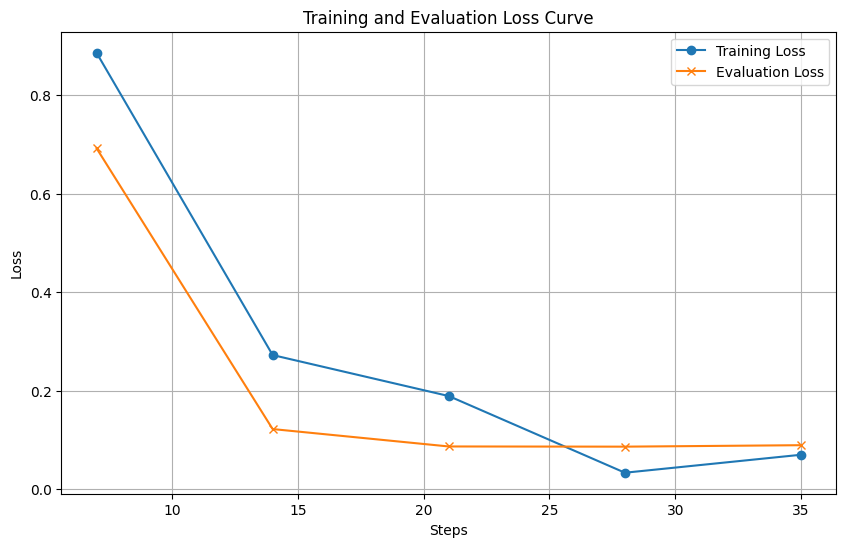

In [78]:
def plot_loss_curve(hist):
    steps = []
    losses = []
    eval_losses = []

    for entry in hist:
        if 'loss' in entry:
            steps.append(entry['step'])
            losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(steps[:len(losses)], losses, label='Training Loss', marker='o')
    plt.plot(steps[:len(eval_losses)], eval_losses, label='Evaluation Loss', marker='x')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss_curve(hist)

In [79]:
preds_res = trainer.predict(data_tokenized['test'])

In [80]:
preds_res.metrics

{'test_loss': 0.08606655150651932,
 'test_accuracy': 0.98,
 'test_runtime': 2.7131,
 'test_samples_per_second': 18.429,
 'test_steps_per_second': 1.474}

In [81]:
preds_tst = preds_res.predictions
preds_tst[:2]

array([[ 1.8227454, -1.8530693],
       [ 1.8235521, -1.8518883]], dtype=float32)

In [82]:
def softmax_(x):
    e_x = np.exp(x - np.max(x))  # subtract max to prevent overflow
    return e_x / e_x.sum(axis=-1, keepdims=True)


In [83]:
softmax_(preds_tst)[:10]

array([[9.7529691e-01, 2.4703067e-02],
       [9.7528785e-01, 2.4712086e-02],
       [9.7529292e-01, 2.4707114e-02],
       [9.4291980e-05, 9.9990565e-01],
       [9.7529614e-01, 2.4703829e-02],
       [9.7530729e-01, 2.4692701e-02],
       [9.7529608e-01, 2.4703912e-02],
       [9.7529566e-01, 2.4704367e-02],
       [9.4312447e-05, 9.9990571e-01],
       [9.4295989e-05, 9.9990571e-01]], dtype=float32)

In [84]:
softmax(preds_tst, axis=-1)[:10]

array([[9.7529691e-01, 2.4703065e-02],
       [9.7528785e-01, 2.4712086e-02],
       [9.7529286e-01, 2.4707114e-02],
       [9.4291980e-05, 9.9990571e-01],
       [9.7529614e-01, 2.4703823e-02],
       [9.7530729e-01, 2.4692694e-02],
       [9.7529614e-01, 2.4703905e-02],
       [9.7529560e-01, 2.4704361e-02],
       [9.4312491e-05, 9.9990571e-01],
       [9.4295945e-05, 9.9990571e-01]], dtype=float32)

In [85]:
preds_cls = np.argmax(softmax_(preds_tst), axis=-1)
y_tst = data_tokenized['test']['label']

print(f'Test Acc: {np.mean(preds_cls == y_tst) * 100:.2f}')

Test Acc: 98.00


In [86]:
preds_df = pd.DataFrame({
    'text': data_tokenized['test']['text'],
    'label': data_tokenized['test']['label'],
    'pred_cls': preds_cls,
    'pred_proba': np.max(softmax_(preds_tst), axis=-1)
})

preds_df.sample(10)

,text,label,pred_cls,pred_proba
27,Black and white checkered kitchen floor adding...,0,0,0.975315
35,Sweet and spicy sushi roll with ingredients li...,1,1,0.999906
40,"Colorful vegetable curry plate, showcasing a v...",1,1,0.999906
38,Sushi platter featuring a rainbow of colors wi...,1,1,0.999906
2,Set of pots and pans hanging from a kitchen rack,0,0,0.975293
3,"Turnips in a bowl, sprinkled with pepper and s...",1,1,0.999906
48,Set of pillows arranged on a couch,0,0,0.975298
29,Camera mounted on a tripod,0,0,0.975315
46,"Comforting lentil dal curry, featuring nutty l...",1,1,0.999906
31,Drone resting on a desk,0,0,0.975287


In [87]:
# Get the wrongly classified examples and order them by how wrongly the model is confident.
df_wrong_pred = preds_df.loc[preds_df['label'] != preds_df['pred_cls']]
df_wrong_pred.sort_values('pred_proba', ascending=False)

,text,label,pred_cls,pred_proba
4,Three apples and two oranges next to each othe...,1,0,0.975296


In [88]:
def set_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():  # mac
        device = 'mps'
    else:
        device = 'cpu'

    return torch.device(device)

DEVICE = set_device()
print(f'[INFO] Using **{DEVICE}**.')

[INFO] Using **cuda**.


In [89]:
# https://huggingface.co/docs/transformers/en/main_classes/pipelines

pipeline_clf = pipeline(
    task='text-classification',
    model=model_path,
    device=DEVICE,
    top_k=1,
    batch_size=8
)

In [90]:
pipeline_clf('Blueberry is delicious.')  # ???

[[{'label': 'food', 'score': 0.999904990196228}]]

In [91]:
samples_txt = [
    'Blueberry is delicious',
    'A whole pizza pie with a thin and crispy crust',
    'Three apples and two oranges next to each other on a kitchen table',
    'The local coffee shop has the best croissants',
    'The local coffee shop has the best croissants.',  # add `.` to the sentence.
    'A yellow tractor driving over a hill.',
    'The plot twist was the icing on the cake.',
]

In [92]:
for txt in samples_txt:
    # the output from pipeline is like the following:
    # [[{'label': 'not_food', 'score': 0.6}]]
    # we want the inner dictionary
    [[res]] = pipeline_clf(txt)
    print(f'SAMPLE: {txt}')
    print(f'Predicted **{res["label"]}** with probability: {res["score"]*100:.2f}%')
    print('=' * 70)

SAMPLE: Blueberry is delicious
Predicted **food** with probability: 99.99%
SAMPLE: A whole pizza pie with a thin and crispy crust
Predicted **food** with probability: 99.99%
SAMPLE: Three apples and two oranges next to each other on a kitchen table
Predicted **not_food** with probability: 97.53%
SAMPLE: The local coffee shop has the best croissants
Predicted **not_food** with probability: 97.53%
SAMPLE: The local coffee shop has the best croissants.
Predicted **not_food** with probability: 97.51%
SAMPLE: A yellow tractor driving over a hill.
Predicted **not_food** with probability: 97.53%
SAMPLE: The plot twist was the icing on the cake.
Predicted **not_food** with probability: 97.51%


In [93]:
# Batch inference is also possible:

pipeline_clf(samples_txt)

[[{'label': 'food', 'score': 0.9999047517776489}],
 [{'label': 'food', 'score': 0.9999055862426758}],
 [{'label': 'not_food', 'score': 0.975296139717102}],
 [{'label': 'not_food', 'score': 0.9752776622772217}],
 [{'label': 'not_food', 'score': 0.975138783454895}],
 [{'label': 'not_food', 'score': 0.975250780582428}],
 [{'label': 'not_food', 'score': 0.9751357436180115}]]

In [94]:
# We can also pass a model from huggingface itself:
pipeline_clf_hf = pipeline(
    task='text-classification',
    model='mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased',
    device=DEVICE,
    top_k=1,
    batch_size=8
)

pipeline_clf_hf

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [95]:
for txt in samples_txt:
    # the output from pipeline is like the following:
    # [[{'label': 'not_food', 'score': 0.6}]]
    # we want the inner dictionary
    [[res]] = pipeline_clf_hf(txt)
    print(f'SAMPLE: {txt}')
    print(f'Predicted **{res["label"]}** with probability: {res["score"]*100:.2f}%')
    print('=' * 70)

SAMPLE: Blueberry is delicious
Predicted **food** with probability: 99.94%
SAMPLE: A whole pizza pie with a thin and crispy crust
Predicted **food** with probability: 99.94%
SAMPLE: Three apples and two oranges next to each other on a kitchen table
Predicted **food** with probability: 99.94%
SAMPLE: The local coffee shop has the best croissants
Predicted **not_food** with probability: 99.85%
SAMPLE: The local coffee shop has the best croissants.
Predicted **food** with probability: 90.32%
SAMPLE: A yellow tractor driving over a hill.
Predicted **not_food** with probability: 99.96%
SAMPLE: The plot twist was the icing on the cake.
Predicted **not_food** with probability: 97.79%


In [96]:
# Make predictions with PyTorch:

txt = samples_txt[0]

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)

# pt is for pytorch
inputs = tokenizer(txt, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  2630,  9766,  2003, 12090,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [97]:
model_ = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_path
)


with torch.inference_mode():
    # outputs is like: SequenceClassifierOutput(loss=None, logits=tensor([[ 1.0331, -1.2807]]))
    outputs = model_(**inputs)

    pred_ix = torch.argmax(outputs.logits, axis=1).item()
    pred_cls = model_.config.id2label[pred_ix]

    proba = torch.softmax(outputs.logits, dim=1).max().item()
    print(f'predicted: **{pred_cls}** with probability {proba*100:.2f}%')

predicted: **food** with probability 99.99%
